# GAN

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [26]:
# 입력 차원 설정
img_shape = (28, 28, 1)

# 이미지 개수
z_dim = 100

## 생성 모델 구성 함수 정의

In [27]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))

    return model

## 분류 모델 구성 함수 정의

In [28]:
# 분류 모델 구성
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

## GAN 모델 구성 함수 정의
생성 모델과 분류 모델을 합쳐 GAN 모델을 완성

In [29]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

## 모델 생성

In [30]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

losses = []
accuracies = []
iteration_checkpoints = []

## 학습 함수 정의

In [31]:
def train(iterations, batch_size, sample_interval):
    
    # MNIST에서 이미지 데이터 불러오기
    (X_train, _), (_, _) = mnist.load_data()
    
    # [0, 255]의 MNIST 이미지를 [-1, 1]로 정규화
    X_train = X_train / 127.5 - 1.0
    
    # 2차원 이미지 여러 장이 투입되므로, 2차원을 3차원으로 확장
    X_train = np.expand_dims(X_train, axis=3)
    
    # 진짜 이미지는 1로, 가짜 이미지는 0으로 초기화
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # 설정한 횟수만큼 학습 반복
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # 랜덤한 노이즈를 생성자에 입력
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # 진양성의 손실값
        d_loss_real = discriminator.train_on_batch(imgs, real)
        
        # 위음성의 손실값
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 진양성 손실값과 위음성 손실값을 평균낸 판별자의 손실값
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # 랜덤한 노이즈 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        
        # 위양성 손실값
        g_loss = gan.train_on_batch(z, real)

        # (설정한 Sample Interval)번에 한 번씩(ex. 1000번에 1번)
        if (iteration + 1) % sample_interval == 0:
            
            # 전체 손실값에 판별자 손실값과 생성자 손실값을 더하기
            losses.append((d_loss, g_loss))
            
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Sample Interval, 분류 모델의 손실값 및 정확도, 생성 모델의 손실값 출력
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # 샘플 이미지 생성 및 출력
            sample_images(generator)

## 샘플 이미지 생성 및 출력 함수 정의

In [32]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    
    # 랜덤한 노이즈 생성
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    # 노이즈로 이미지 생성
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # 이미지 출력 형태 지정
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

    # 격자 형태로 이미지 출력
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## 학습 진행 및 결과 출력

1000 [D loss: 0.057184, acc.: 99.61%] [G loss: 3.333447]
2000 [D loss: 0.058925, acc.: 98.05%] [G loss: 5.651768]
3000 [D loss: 0.068169, acc.: 98.05%] [G loss: 5.935148]
4000 [D loss: 0.198570, acc.: 89.84%] [G loss: 5.624820]
5000 [D loss: 0.190452, acc.: 91.41%] [G loss: 4.245870]
6000 [D loss: 0.187160, acc.: 92.58%] [G loss: 5.472705]
7000 [D loss: 0.301222, acc.: 87.89%] [G loss: 4.427504]
8000 [D loss: 0.293571, acc.: 90.23%] [G loss: 4.144492]
9000 [D loss: 0.354606, acc.: 84.38%] [G loss: 3.485194]
10000 [D loss: 0.386611, acc.: 83.98%] [G loss: 3.063482]


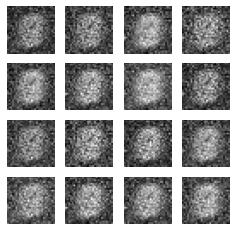

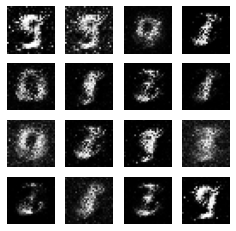

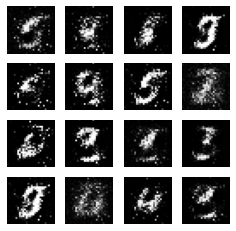

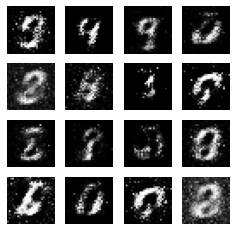

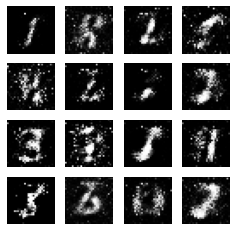

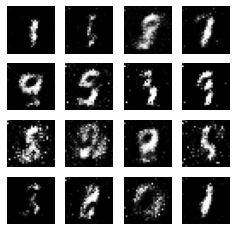

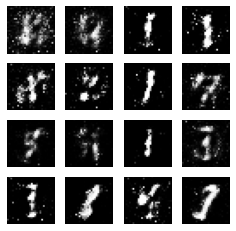

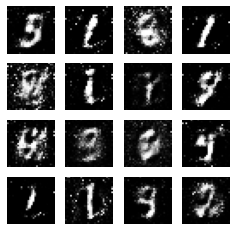

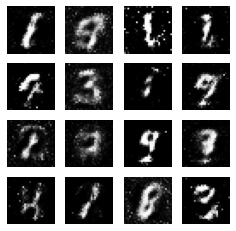

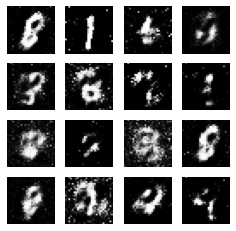

In [33]:
# Iterations, Batch Size, Sample Interval
train(10000, 128, 1000)